In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

/Library/Python/2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [6]:
pwd

u'/Users/zuzia/Desktop/Coding/DataKind_GivingTuesday'

# Objective for DataKind Giving Tuesday DataDive

This notebook demonstrates how to normalize charitable donations by median income within each zip code. It is necessary if we want to investigate what proportion of households' income is given to charity. For each ZIP code we did the following adjustment:

\begin{equation*}NormalizedDonation = \frac{\sum_{donations} DonationAmount}{medianHouseholdIncome * NumHouseholds }\end{equation*}

Finally, it adds the converted values into zip code shapefiles provided by the US Census. Resulting map can be seen at: https://zuzanna.carto.com/viz/999bdc1a-01c1-11e7-9bf4-0e3ff518bd15/map

In [7]:
donations_sample = pd.read_csv("/Users/zuzia/Desktop/DataKind/donations_sample.csv")

I carved out 2016 data from the 2.4GB dataset with 2007-2016 data using the grep funciton in the terminal:

    cat donations_post_gt.csv | grep 2016 >> donations_post_gt_2016.csv
    
It ommitted everything that didn't have '2016' in it, which includes the columns:). It means we need to grab them from somewhere else - I used a different sample.

In [8]:
donations_2016 = pd.read_csv("/Users/zuzia/Desktop/DataKind/donations_post_gt_2016.csv")
zips = pd.read_csv("/Users/zuzia/Desktop/DataKind/us_postal_codes_2012.csv")
donations_2016.columns = donations_sample.columns

## Cleaning ZIP codes
ZIP codes are in a variety of formats (e.g. 10003 and 10003-12345) and are stored both as floats and strings. We need to unify the format in order to push them through the geolocation tools later on.

In [9]:
def zip_transform(s):  
    """
    this function cleans ZIP code data to make sure it can 
    be merged between data sets
    
    input: str/float/int
    output: str
    
    """
    s = str(s)
        
    if s == 'nan':
        return np.nan
    s = s.lstrip(' ')
    s = s.rstrip(' ')
    s = s.split(".")[0]
    s = s.split("-")[0]
    s = s.split(" ")[0]
    s = s.zfill(5)
    
    if len(s) != 5:
        raise AssertionError()
        
    return s

## Choose only donations smaller than 200 USD

We care only about small donations for the #GivingTuesday initiative so it is important to sift through large corporate donations and leave only small ones. I chose 200 USD as opposed to, say, 400 or a 1000 based on an elbow in a histogram of all donation amounts - the number of donations above 200 USD dropped rapidly.

In [10]:
donations_2016.dropna(subset=['DonorZip'], inplace=True)
zips['DonorZip'] = zips['Postal Code']
zips.dropna(subset=['DonorZip'], inplace=True)

# Interested only in small donations, defined as < 200 USD
donations_2016 = donations_2016[donations_2016.DonationAmount < 200]

donations_2016['DonorZip'] = donations_2016['DonorZip'].apply(zip_transform)
zips['DonorZip'] = zips['DonorZip'].apply(zip_transform)

In [11]:
donations_2016.head()

,DonationAmount,DonationDate,DonationTime,DonationType,DonorZip,FirstDonation,IRS_Activity,IRS_Ntee,IRS_Org_Zip,InfAdjAmnt,...,org_postal_code,project_id,project_primary_theme,recurring_count,recurring_id,transaction_id,user_id,volume_bucket,year,zip
2,80.0,2012-12-07,31208.0,NaN,20165,NaN,0,B20,20191-1637,84.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012.0,20165.0
3,50.0,2012-12-15,30922.0,NaN,20165,NaN,560000000,X20Z,20175-8916,52.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012.0,20165.0
4,50.0,2012-12-10,63605.0,NaN,20011,NaN,0,O50,20169-1918,52.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012.0,20011.0
5,100.0,2012-12-19,66067.0,NaN,20166,NaN,0,I44,11201-3631,105.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012.0,20166.0
6,75.0,2012-12-21,66323.0,NaN,20165,NaN,0,A70,75214-0962,78.75,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012.0,20165.0


## Clean and merge in 2016 demographic data
Now, we're still missing some context. We have the donation amount but how can we normalize it, or, in other words, put it in the context of income within the area? I merged our dataset with federal census data which contains information about income per household and the number of households within corresponding zip codes. 

It's a bit tricky - the "income per household" is the median income, so multiplied by the number of incomes gives us **an approximation of mean income**, not the actual mean. However, for the purpose of this project and considering the availability of this dataset I decided to use it.

In [12]:
df_demography = pd.read_csv('/Users/zuzia/Desktop/DataKind/feb2017-zip-demography.csv')

This dataset contains a lot of redundant information. After visual inspection I realized you have to filter out redundant entries by using only primary records:

In [13]:
df_demography = df_demography[df_demography['PrimaryRecord'] == 'P']

In [14]:
df_demography['ZipCode'] = df_demography['ZipCode'].apply(zip_transform)
df_income = df_demography[['ZipCode', 'IncomePerHousehold','HouseholdsPerZipCode']]
df_income.columns = ['DonorZip', 'IncomePerHousehold','HouseholdsPerZipCode']

In [15]:
totals_per_zip = donations_2016.groupby(by='DonorZip').sum()['DonationAmount']
totals_per_zip = pd.DataFrame(totals_per_zip)
totals_per_zip['DonorZip'] = totals_per_zip.index

If you know SQL, merging in Pandas is very similar, you also indicate the column you're merging on (here: 'DonorZip'). That's why it was important to clean them with the zip_transform function!

In [16]:
df = pd.merge(totals_per_zip, df_income, on='DonorZip', how='inner')
df = pd.merge(df,
              zips,
              on=['DonorZip'], 
              suffixes=('_donations_sample','_zips'))

df['IncomePerZipcode']=df['IncomePerHousehold'] * df['HouseholdsPerZipCode']
df['DonationAmountPerIncome'] = df['DonationAmount'] / df['IncomePerZipcode']

## Plot normalized donations as a histogram

In [17]:
df = df[df['DonationAmountPerIncome']!=np.inf] # Histogram function doesn't like infinity
df.dropna(inplace=True, subset=['DonationAmountPerIncome'])

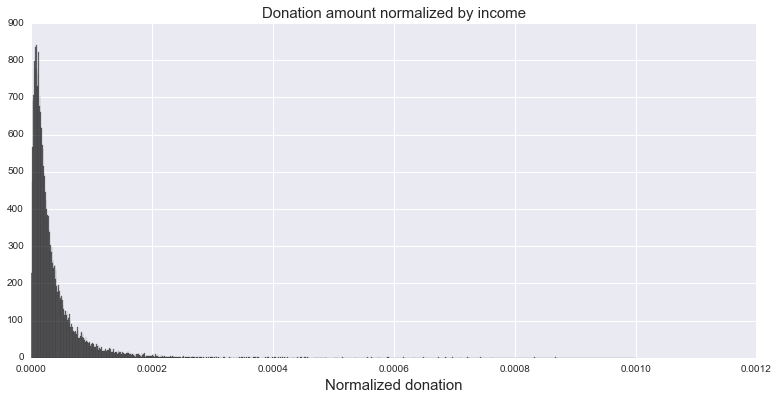

In [22]:
fig = plt.figure(figsize = [13,6])
bins = np.linspace(0,0.001,1000)
ax = df['DonationAmountPerIncome'].hist(color='k', alpha=0.5, bins=bins)
ax.set_xlabel('Normalized donation', size=15)
plt.title('Donation amount normalized by income', size=15)
plt.show()

## Save the data frame 
First take a peak to make sure everything looks right.

In [51]:
df.head()

,DonationAmount,DonorZip,IncomePerHousehold,HouseholdsPerZipCode,Postal Code,Place Name,State,State Abbreviation,County,Latitude,Longitude,Unnamed: 7,IncomePerZipcode,DonationAmountPerIncome
2,15699.76,01001,60161,7215,1001.0,Agawam,Massachusetts,MA,Hampden,42.0702,-72.6227,NaN,434061615,0.000036
3,114674.05,01002,50540,9910,1002.0,Amherst,Massachusetts,MA,Hampshire,42.3671,-72.4646,NaN,500851400,0.000229
6,6216.88,01005,68786,1904,1005.0,Barre,Massachusetts,MA,Worcester,42.4097,-72.1084,NaN,130968544,0.000047
7,32172.70,01007,76881,5595,1007.0,Belchertown,Massachusetts,MA,Hampshire,42.2751,-72.4110,NaN,430149195,0.000075
8,3199.00,01008,70417,503,1008.0,Blandford,Massachusetts,MA,Hampden,42.1829,-72.9361,NaN,35419751,0.000090


In [43]:
df.to_csv("/Users/zuzia/Desktop/DataKind/normalized_less_than_200_donations_2016.csv")

# GeoPandas:  squishing our data into ZIP code shape files
In our dataset we have only ZIP code information and longitude / latidute information about the center of each ZIP code. If we plot it on the map as points, we would be misrepresenting the spatial component which, by nature, has to visualized in the geospatial context (duh). In order to do that we need to grab the shapefiles from the federal census data (freely accessible) and use GeoPandas to merge two data sets (again, in a similar way to SQL).

In [8]:
donations = gpd.GeoDataFrame.from_file("normalized_less_than_200_donations_2016.geojson") 

zips = gpd.GeoDataFrame.from_file("cb_2015_us_zcta510_500k.geojson") 

donzip = donations.merge(zips, left_on="donorzip", right_on="zcta5ce10", how="outer")


Once we're done with it, we need to export it, save it (it will give a bunch of errors, it's fine) and visualize it. One free and cool tool to do that is Carto.com. If you have access to, say, ArcGIS or QGIS, that's an option too. I chose Carto since it's web based. The resulting map can be accessed at https://zuzanna.carto.com/viz/999bdc1a-01c1-11e7-9bf4-0e3ff518bd15/map.

In [ ]:
donzip["geometry"] = donzip["geometry_y"]

donzip  = gpd.GeoDataFrame(donzip)

final = donzip.dissolve(by='donorzip', aggfunc='sum')

final.to_file("donationsbyzip") 
